In [1]:
import os, sys
module_rootdir = '.'
dataset_rootdir = '.'
label_rootdir = module_rootdir
sys.path.append(module_rootdir)

from modules.set_configurations.set_config_cnn import config
from modules.set_configurations.set_param_for_training_cnn import set_parameters_for_training
from modules.compute_features.grid_features import grid_properties

config_file_path = 'configuration_radarscenes_cnn.yml'
config_obj = config(config_file_path)

objects_dict = set_parameters_for_training(
    module_rootdir = module_rootdir,
    dataset_rootdir = dataset_rootdir,
    config_obj = config_obj,
    batch_size = 1,
    starting_iter_num = 0,
    load_model_weights_train = False,
    trained_weights_path = '')

grid_obj = grid_properties(
    min_x = config_obj.min_x, max_x = config_obj.max_x, 
    min_y = config_obj.min_y, max_y = config_obj.max_y, 
    min_sigma_x = config_obj.min_sigma_x, max_sigma_x = config_obj.max_sigma_x, 
    min_sigma_y = config_obj.min_sigma_y, max_sigma_y = config_obj.max_sigma_y, 
    dx = config_obj.dx, dy = config_obj.dy)

detector = objects_dict['detector']
optimizer = objects_dict['optimizer']

device = 'cuda'

GPU is available. Good to go!


100%|██████████| 158/158 [00:14<00:00, 11.04it/s]


## Get Training Data

In [2]:
import numpy as np
import torch
from modules.compute_features.grid_features import compute_encodings
from modules.data_utils.read_data import get_sequence_data, extract_frame
from modules.data_utils.labels import compute_new_labels_to_id_dict, compute_old_to_new_label_id_map
from modules.compute_groundtruth.compute_node_labels import compute_ground_truth as compute_ground_truth_node
from modules.plot_utils.plot_func import plot_channels, plot_range_rates, plot_meas_and_gt_labels_cluster_centers

sequence_name = 'sequence_108'
dataset_path = config_obj.dataset_path
window_size = config_obj.window_size
scene_metadata, radar_mount_data, radar_data_all_scenes, odometry_data_all_scenes \
    = get_sequence_data(dataset_rootdir, dataset_path, sequence_name, window_size)

data_dict = extract_frame(
    idx = 40, 
    windowed_data_list = scene_metadata,
    radar_mount_data = radar_mount_data,
    radar_data_all_scenes = radar_data_all_scenes,
    odometry_data_all_scenes = odometry_data_all_scenes,
    reject_outlier = False)

labels_to_id_dict = compute_new_labels_to_id_dict()
old_to_new_label_id_map = compute_old_to_new_label_id_map()
gt_dict_node = compute_ground_truth_node(data_dict, labels_to_id_dict, old_to_new_label_id_map)
data_dict, gt_dict_node = grid_obj.select_meas_within_the_grid(data_dict, gt_dict_node)

# select data assuming only one measurement can lie within the grid cell
meas_xy_coord_grid, meas_vr_grid, meas_rcs_grid, gt_labels_grid, gt_offsets_grid \
    = grid_obj.gridify_measurements_and_labels(
        np.stack((data_dict['meas_px'], data_dict['meas_py']), axis=-1), 
        data_dict['meas_vr'], data_dict['meas_rcs'], 
        gt_dict_node['class_labels'], 
        np.stack((gt_dict_node['offsetx'], gt_dict_node['offsety']), axis=-1))
        
# compute input feature maps
meas_cov = grid_obj.compute_covariance_linearly_varying(meas_xy_coord_grid[:,0], meas_xy_coord_grid[:,1])
meas_likelihood_map, range_map, azimuth_map \
    = compute_encodings(grid_obj.xy_coord, meas_xy_coord_grid, meas_cov, device)

# inputs
image_grid = torch.stack((meas_likelihood_map, range_map, azimuth_map), axis=0).unsqueeze(0)
meas_vr_grid = torch.from_numpy(meas_vr_grid).to(device).to(torch.float32).unsqueeze(0)
meas_rcs_grid = torch.from_numpy(meas_rcs_grid).to(device).to(torch.float32).unsqueeze(0)

# label dictionary
labels = {}
labels['class'] = torch.from_numpy(gt_labels_grid).to(device).to(torch.float32).unsqueeze(0)
labels['offsets'] = torch.from_numpy(gt_offsets_grid).to(device).to(torch.float32).unsqueeze(0)

## Visualize Data

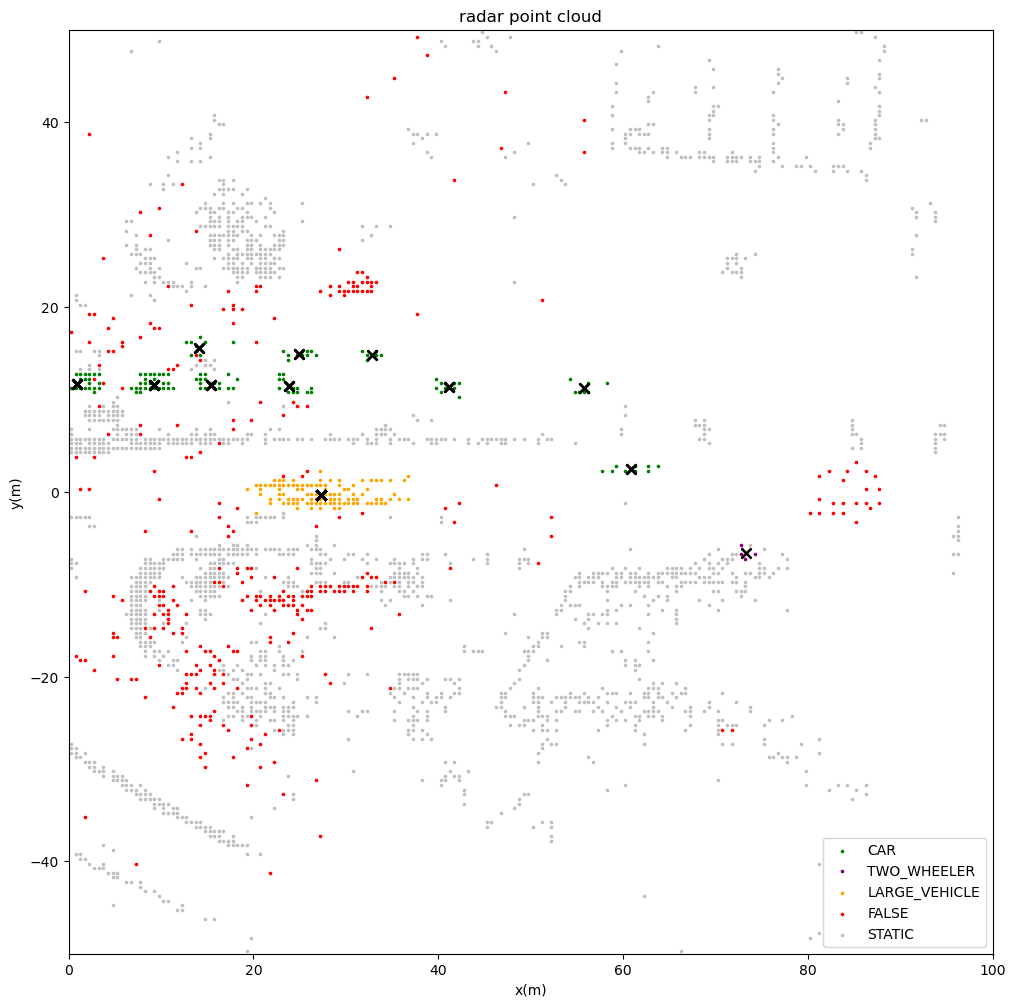

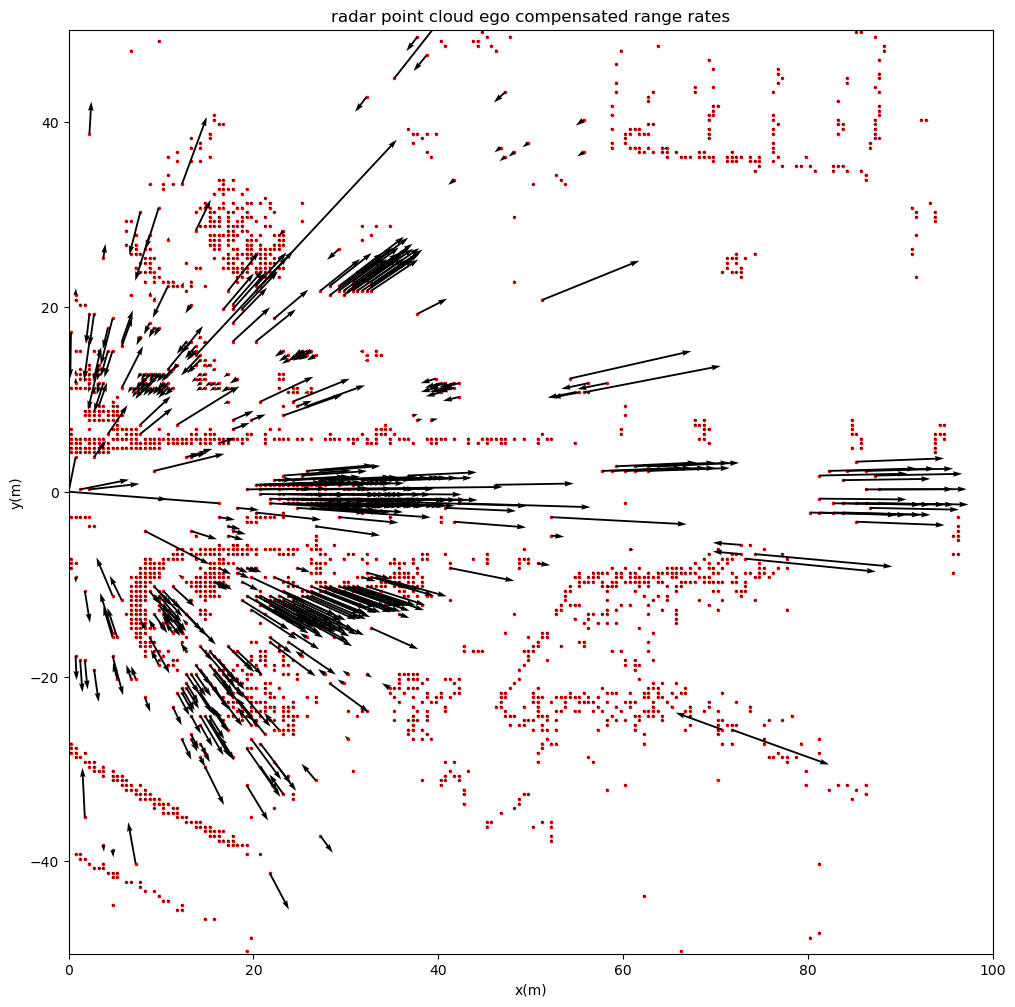

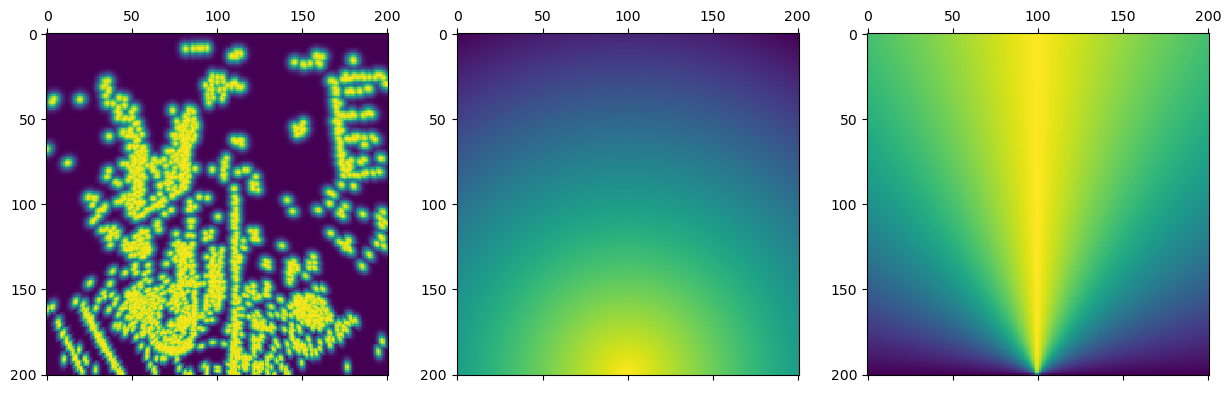

In [3]:
gt_labels_grid_np = labels['class'][0].detach().cpu().numpy()
gt_offsets_grid_np = labels['offsets'][0].detach().cpu().numpy()
meas_vr_grid_np = meas_vr_grid[0].detach().cpu().numpy()
meas_xy_coord_grid_np = meas_xy_coord_grid

flag_valid_meas = (gt_labels_grid_np > -99999).reshape(-1)
flag_valid_objects = np.logical_and(gt_labels_grid_np > -99999, 
                        np.logical_and(gt_labels_grid_np != labels_to_id_dict['FALSE'], 
                                       gt_labels_grid_np != labels_to_id_dict['STATIC'])).reshape(-1)
flag_stationary = np.logical_and(gt_labels_grid_np > -99999, gt_labels_grid_np == labels_to_id_dict['STATIC']).reshape(-1)

vr_grid_meas = meas_vr_grid_np.reshape(-1)
xy_coord_meas = meas_xy_coord_grid_np
xy_coord_grid = grid_obj.xy_coord.reshape(-1,2)
gt_offset = gt_offsets_grid_np.reshape(-1, 2)

gt_labels_grid_meas = gt_labels_grid[gt_labels_grid_np > -99999].reshape(-1)
flag_valid_objects_meas = np.logical_and(gt_labels_grid_meas != labels_to_id_dict['FALSE'], 
                                         gt_labels_grid_meas != labels_to_id_dict['STATIC']).reshape(-1)

cluster_centers_x = xy_coord_meas[flag_valid_objects_meas, 0] + gt_offset[flag_valid_objects, 0]
cluster_centers_y = xy_coord_meas[flag_valid_objects_meas, 1] + gt_offset[flag_valid_objects, 1]

meas_px = xy_coord_grid[flag_valid_meas, 0]
meas_py = xy_coord_grid[flag_valid_meas, 1]
vr_grid_meas = vr_grid_meas[flag_valid_meas]

# plot_measurements(meas_px, meas_py, figsize=(12, 12), xlim_min=0, xlim_max=100, ylim_min=-50, ylim_max=50)

# plot_track_centers(
#     meas_px, meas_py, cluster_centers_x, cluster_centers_y, figsize=(12, 12), 
#     xlim_min=0, xlim_max=100, ylim_min=-50, ylim_max=50)

# cluster_centers_x = meas_px + gt_offsets_dyn[:,0]
# cluster_centers_y = meas_py + gt_offsets_dyn[:,1]
# flag = gt_labels_dyn != 6

all_labels = config_obj.object_classes
plot_meas_and_gt_labels_cluster_centers(
    meas_px, meas_py, cluster_centers_x, cluster_centers_y, 
    gt_labels_grid_meas, all_labels , figsize = (12, 12))

from modules.data_utils.meas_sync import vel_polar_to_cart
meas_vx, meas_vy = vel_polar_to_cart(vr_grid_meas, meas_px, meas_py)
plot_range_rates(meas_px, meas_py, meas_vx, meas_vy, figsize=(12, 12))

plot_channels(image_grid[0].detach().cpu().numpy())

## Overfit the model

In [4]:
max_iters = 2000
iter_start_offset = 0
for iter_train_outer in range(iter_start_offset, max_iters):

    loss = detector(image_grid, labels['class'], labels['offsets'], meas_vr_grid, meas_rcs_grid)
    total_loss = loss['loss_cls'] + loss['loss_reg']

    total_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    loss_str = f"[Iter {iter_train_outer}][loss: {total_loss.item():.8f}]"
    for key, value in loss.items():
        loss_str += f"[{key}: {value.item():.8f}]"
    print(loss_str)

[Iter 0][loss: 2.04450631][loss_cls: 1.15898073][loss_reg: 0.88552558]
[Iter 1][loss: 2.04354548][loss_cls: 1.15866685][loss_reg: 0.88487870]
[Iter 2][loss: 2.04177928][loss_cls: 1.15805888][loss_reg: 0.88372040]
[Iter 3][loss: 2.03937864][loss_cls: 1.15717053][loss_reg: 0.88220823]
[Iter 4][loss: 2.03654337][loss_cls: 1.15602124][loss_reg: 0.88052213]
[Iter 5][loss: 2.03339124][loss_cls: 1.15463626][loss_reg: 0.87875491]
[Iter 6][loss: 2.03022838][loss_cls: 1.15309250][loss_reg: 0.87713587]
[Iter 7][loss: 2.02733803][loss_cls: 1.15144837][loss_reg: 0.87588978]
[Iter 8][loss: 2.02437830][loss_cls: 1.14971495][loss_reg: 0.87466323]
[Iter 9][loss: 2.02134347][loss_cls: 1.14786184][loss_reg: 0.87348163]
[Iter 10][loss: 2.01819658][loss_cls: 1.14586723][loss_reg: 0.87232947]
[Iter 11][loss: 2.01466751][loss_cls: 1.14372158][loss_reg: 0.87094593]
[Iter 12][loss: 2.01089144][loss_cls: 1.14146626][loss_reg: 0.86942524]
[Iter 13][loss: 2.00666738][loss_cls: 1.13914907][loss_reg: 0.86751825]
[I

## Plot Predictions

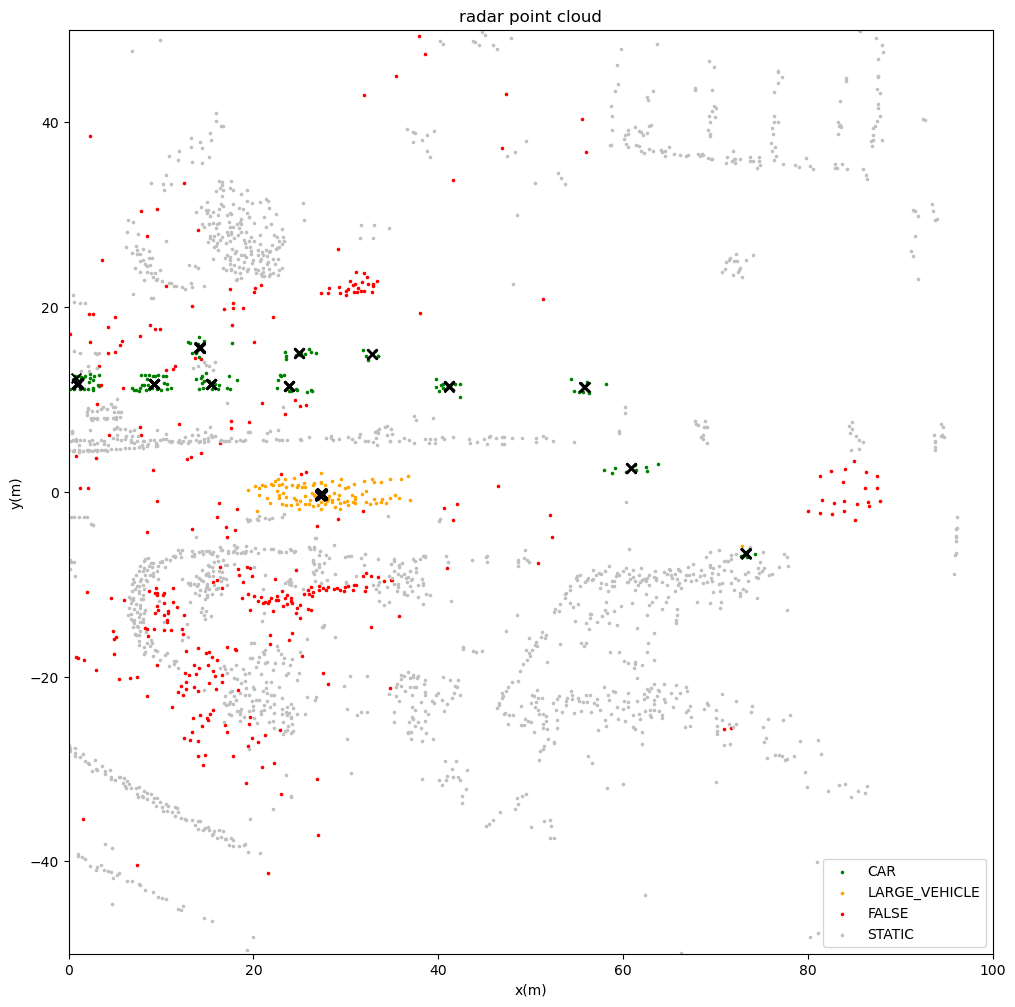

In [5]:
import torch.nn.functional as F
from modules.compute_groundtruth.compute_offsets import unnormalize_gt_offsets

# extract predictions
predictor = detector.pred.eval()
pred_class_logits, pred_reg_deltas = predictor(image_grid, labels['class'], meas_vr_grid, meas_rcs_grid)

# compute class prediction
cls_prob = F.softmax(pred_class_logits, dim=-1)
cls_score, cls_idx = torch.max(cls_prob, dim=-1)

# compute offsets
offset_mu = config_obj.offset_mu
offset_sigma = config_obj.offset_sigma
pred_reg_deltas = unnormalize_gt_offsets(pred_reg_deltas, offset_mu, offset_sigma)
xy_coord_meas_ = torch.from_numpy(meas_xy_coord_grid).to(device).to(torch.float32)

valid_dynamic_meas_flag = torch.logical_and(cls_idx != labels_to_id_dict['STATIC'], cls_idx != labels_to_id_dict['FALSE'])
pred_cluster_centers_x = xy_coord_meas_[valid_dynamic_meas_flag, 0] + pred_reg_deltas[valid_dynamic_meas_flag, 0]
pred_cluster_centers_y = xy_coord_meas_[valid_dynamic_meas_flag, 1] + pred_reg_deltas[valid_dynamic_meas_flag, 1]

plot_meas_and_gt_labels_cluster_centers(
    meas_xy_coord_grid[:,0], 
    meas_xy_coord_grid[:,1], 
    pred_cluster_centers_x.detach().cpu().numpy(), 
    pred_cluster_centers_y.detach().cpu().numpy(), 
    cls_idx.detach().cpu().numpy(), config_obj.object_classes , figsize = (12, 12))